In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
from physvae import utils
from physvae.pendulum.model import VAE

In [3]:
# setting
datadir = './data/pendulum'
dataname = 'test'
modeldir = './out_pendulum/'

In [4]:
# load data
data_test = np.loadtxt('{}/data_{}.txt'.format(datadir, dataname))

# load ture parameters
params_test = np.loadtxt('{}/true_params_{}.txt'.format(datadir, dataname))

In [5]:
device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set and load model (aux only)
with open('{}/args.json'.format(modeldir), 'r') as f:
    args_tr_dict = json.load(f)
model = VAE(args_tr_dict).to(device)
model.load_state_dict(torch.load('{}/model.pt'.format(modeldir), map_location=device))
model.eval()

dim_t_tr = args_tr_dict['dim_t']
dt = args_tr_dict['dt']

In [6]:
# infer latent variables using short data
data_tensor = torch.Tensor(data_test).to(device)
init_y = data_tensor[:,0].clone().view(-1,1)

with torch.no_grad():
    # aux only
    z_phy_stat, z_aux1_stat, z_aux2_stat, unmixed = model.encode(data_tensor)
    z_phy, z_aux1, z_aux2 = model.draw(z_phy_stat, z_aux1_stat, z_aux2_stat, hard_z=False)

In [7]:
# generate counterfactual from learned model

# NOTE: training data's omega range is only [0.785, 3.14]
coeffs = [0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0] # coefficients that multiply original value of omega
cf_z_phy = [ [] for i in range(len(coeffs)) ]
for i in range(len(coeffs)):
    cf_z_phy[i] = z_phy*coeffs[i]

with torch.no_grad():
    cf_x = [ [] for i in range(len(coeffs)) ]
    for i in range(len(coeffs)):
        cf_x[i], _ = model.decode(cf_z_phy[i], z_aux1, z_aux2, init_y)
        cf_x[i] = cf_x[i].cpu().numpy()

In [10]:
# generate true signals
import sys; sys.path.append('./data/pendulum/')
from generate import generate_traj

n = 30 #params_test.shape[0]
dim_t = data_tensor.shape[1]
cf_x_true = [ np.empty((n, dim_t)) for i in range(len(coeffs)) ]
for i in range(n):
    init_cond = [params_test[i,0], 0.0]
    gamma = params_test[i,2]
    A = params_test[i,3]
    f = params_test[i,4]
    for j in range(len(coeffs)):
        t, tmp = generate_traj(init_cond, cf_z_phy[j][i][0], gamma, A, f, dt, dim_t)
        cf_x_true[j][i] = tmp[:,0]

0.42046210169792175
0.8409242033958435
1.2613862752914429
1.681848406791687
2.1023104190826416
3.153465747833252
4.204620838165283
5.2557759284973145
6.306931495666504


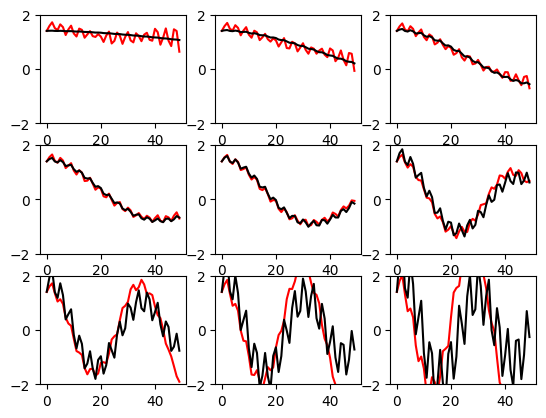

In [11]:
# show
idx = 29
plt.figure()
for i in range(len(coeffs)):
    print(cf_z_phy[i][idx].item())
    plt.subplot(3,3,i+1)
    plt.plot(cf_x[i][idx], 'r')
    plt.plot(cf_x_true[i][idx], 'k')
    plt.ylim([-2.0, 2.0])
plt.show()